In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import  Dropout, Reshape
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.initializers import glorot_uniform
from keras.models import Model

In [3]:
def reshaping(x):
  return np.reshape(x,(32,32))

a = np.load('/content/drive/MyDrive/cvpr dataset/train_data.npz')
x_train, y_train = a['arr_0'], a['arr_1']

xx_train = list((map(reshaping,x_train)))
x_train_ = np.array(xx_train)


b = np.load('/content/drive/MyDrive/cvpr dataset/test_data.npz')
x_test, y_test = b['arr_0'], b['arr_1']

xx_test = list((map(reshaping,x_test)))
x_test_ = np.array(xx_test)

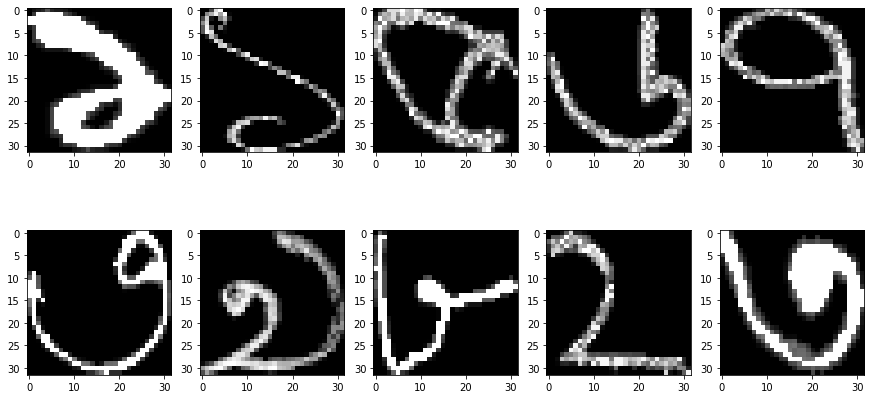

Labels : [[1]
 [1]
 [5]
 [6]
 [7]]
Labels : [[3]
 [9]
 [8]
 [2]
 [3]]


In [4]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_train_[i], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_train_[i+6], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("Labels : {}".format(y_train[0:5]))
print("Labels : {}".format(y_train[6:11]))

In [5]:
# Normalizing the input
x_train_ = x_train_.astype('float32')
x_train_/=255

x_test_ = x_test_.astype('float32')
x_test_/=255

print(x_train_.shape)
print(x_test_.shape)

(18000, 32, 32)
(4000, 32, 32)


In [6]:
y_train_ = to_categorical(y_train, num_classes=10, dtype='float32')
y_test_ = to_categorical(y_test, num_classes=10, dtype='float32')

print("Train Set Size = {} images".format(y_train.shape[0]))
print("Test Set Size = {} images".format(y_test.shape[0]))

Train Set Size = 18000 images
Test Set Size = 4000 images


In [7]:
optimizer = 'adam'
objective = 'categorical_crossentropy'

def identity_block(X, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    X_shortcut = Conv2D(F3, kernel_size=(1,1), strides=(s,s), name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def resNet():
    
    # Define the input as a tensor with shape input_shape
    X_input = Input((32,32,1))
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1',)(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    '''
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    
    '''

    # AVGPOOL
    X = AveragePooling2D((2,2), name='avg_pool')(X)
    
    # output layer
    X = Dropout(rate=.2)(X)
    X = Flatten()(X)
    X = Dropout(rate=.5)(X)

    X = Dense(2048, activation='relu', name='fc1')(X)
    X = Dropout(rate=.2)(X)
    X = Dense(1024, activation='relu', name='fc2')(X)
    X = Dropout(rate=.2)(X)

    X = Dense(y_train_.shape[1], activation='softmax', name='predictions' + str(y_train_.shape[1]))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    
    #Compile the model
    model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])
    
    return model

In [8]:
model_n = resNet()
model_n.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 16, 16, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1[0][0]']                  
                                                                                           

In [9]:
nb_epoch = 100
batch_size = 64

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

ret = model_n.fit(x_train_.reshape((-1,32,32,1)), y_train_, 
                  epochs=nb_epoch, batch_size=batch_size, verbose=1,
                  #validation_split=0.3,
                  validation_data=(x_test_, y_test_),
                  callbacks=[es])

Epoch 1/100
282/282 [==============================] - 32s 62ms/step - loss: 0.8612 - accuracy: 0.7878 - val_loss: 1.9614 - val_accuracy: 0.3758
Epoch 2/100
282/282 [==============================] - 13s 46ms/step - loss: 0.1086 - accuracy: 0.9660 - val_loss: 0.0996 - val_accuracy: 0.9670
Epoch 3/100
282/282 [==============================] - 13s 46ms/step - loss: 0.0802 - accuracy: 0.9767 - val_loss: 0.1812 - val_accuracy: 0.9532
Epoch 4/100
282/282 [==============================] - 13s 46ms/step - loss: 0.0636 - accuracy: 0.9823 - val_loss: 0.9028 - val_accuracy: 0.8555
Epoch 5/100
282/282 [==============================] - 13s 46ms/step - loss: 0.0605 - accuracy: 0.9841 - val_loss: 0.1048 - val_accuracy: 0.9737
Epoch 6/100
282/282 [==============================] - 14s 49ms/step - loss: 0.0404 - accuracy: 0.9887 - val_loss: 0.1544 - val_accuracy: 0.9607
Epoch 7/100
282/282 [==============================] - 13s 46ms/step - loss: 0.0398 - accuracy: 0.9896 - val_loss: 0.0698 - val_ac

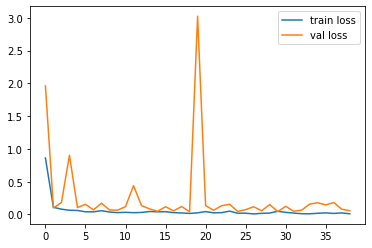

In [10]:
plt.plot(ret.history['loss'], label='train loss')
plt.plot(ret.history['val_loss'], label='val loss')
plt.legend()
plt.show()

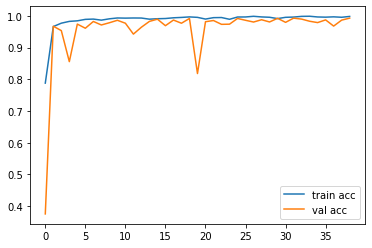

In [11]:
plt.plot(ret.history['accuracy'], label='train acc')
plt.plot(ret.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [12]:
# evaluate the model
_, train_acc = model_n.evaluate(x_train_, y_train_, verbose=0)
_, test_acc = model_n.evaluate(x_test_, y_test_, verbose=0)
print('Train accuracy: %.3f, Test accuracy: %.3f' % (train_acc, test_acc))

Train accuracy: 1.000, Test accuracy: 0.993


In [13]:
predictions = model_n.predict(x_test_.reshape((-1,32,32,1)), verbose=0)

In [14]:
def test_accuracy():
    err = []
    t = 0
    for i in range(predictions.shape[0]):
        if (np.argmax(predictions[i]) == y_test[i]):
            t = t+1
        else:
            err.append(i)
    return t, float(t)*100/predictions.shape[0], err

In [15]:
p = test_accuracy()
print("Test accuracy: {} %".format(p[1]))

Test accuracy: 99.25 %


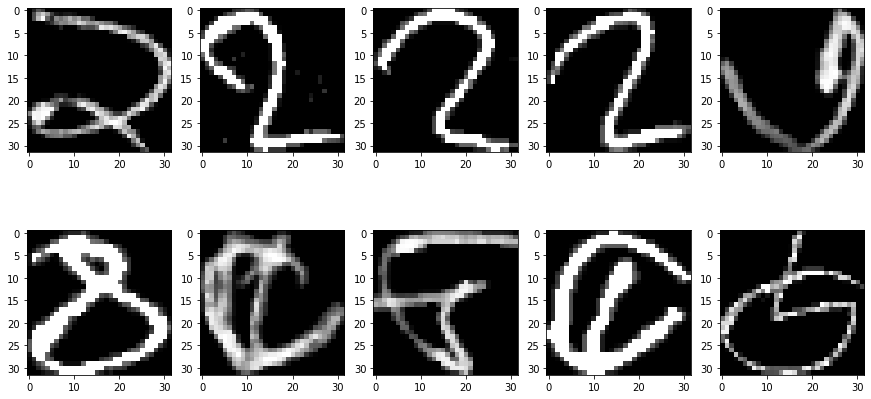

True:          [[1]
 [2]
 [2]
 [2]
 [3]]
classified as: [2 7 7 7 6]
True:          [[4]
 [5]
 [5]
 [5]
 [5]]
classified as: [1 0 4 0 4]


In [16]:
fig1 = plt.figure(figsize = (15,15))

for i in range(5):
    ax1 = fig1.add_subplot(1,5,i+1) 
    ax1.imshow(x_test_[p[2][i]], interpolation='none', cmap=plt.cm.gray)
    ax2 = fig1.add_subplot(2,5,i+6) 
    ax2.imshow(x_test_[p[2][i+6]], interpolation='none', cmap=plt.cm.gray)
plt.show()

print("True:          {}".format(y_test[p[2][0:5]]))
print("classified as: {}".format(np.argmax(predictions[p[2][0:5]], axis=1)))

print("True:          {}".format(y_test[p[2][6:11]]))
print("classified as: {}".format(np.argmax(predictions[p[2][6:11]], axis=1)))